# importing libaries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from datetime import datetime, timedelta
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import keras_tuner
from sklearn.metrics.pairwise import cosine_similarity
import yfinance as yf


# Function to download stock data


In [15]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


# Function to preprocess data and create sequences

In [16]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return np.array(sequences)


# Function to build and train the LSTM model


In [17]:
def build_tunable_lstm_model(hp, sequence_length):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=200, step=50),
                   input_shape=(sequence_length, 1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [18]:
lambda hp: build_tunable_lstm_model(hp, sequence_length)


<function __main__.<lambda>(hp)>

# Function for hyperparameter tuning

In [19]:
def tune_hyperparameters_tuner(train_data, val_data, sequence_length):
    tuner = RandomSearch(
        lambda hp: build_tunable_lstm_model(hp, sequence_length),
        objective='val_loss',
        max_trials=10,
        directory='keras_tuner_dir',
        project_name='stock_price_prediction')

    tuner.search(train_data[0], train_data[1],
                 epochs=50,
                 batch_size=32,
                 validation_data=val_data,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_mse = best_model.evaluate(val_data[0], val_data[1])
    return best_model, best_mse


# function to generate_dates

In [20]:
def generate_dates(start_date, end_date, sequence_length):
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    predicted_dates = [end_date + timedelta(days=i) for i in range(1, sequence_length + 1)]
    return predicted_dates


# Function to predict stock prices

In [21]:
def predict_stock_prices(model, test_data):
    predictions = model.predict(test_data)
    return predictions


# function to recommend stocks name

In [22]:
def recommend_stock_names_cosine_similarity(search_query, stock_names, stock_sector_mapping):
    search_query_sector = stock_sector_mapping.get(search_query, "")
    
    filtered_stock_names = [stock_name for stock_name, sector in zip(stock_names, stock_sector_mapping.values()) if sector.lower() == search_query_sector.lower()]
    
    vectorizer = TfidfVectorizer()
    stock_name_vectors = vectorizer.fit_transform(filtered_stock_names)
    
    search_query_vector = vectorizer.transform([search_query])
    
    similarities = cosine_similarity(search_query_vector, stock_name_vectors)
    
    top_indices = similarities.argsort()[0][-6:][::-1]  # Increase by one to include the search query itself
    
    recommended_stocks = [(filtered_stock_names[i], search_query_sector) for i in top_indices if filtered_stock_names[i].lower() != search_query.lower()]
    
    return recommended_stocks[:5]  # Return top 5 recommendations


# loading a file

In [23]:
def load_stock_data_from_file(filename):
    stock_data = {}
    with open(filename, 'r') as f:
        exec(f.read(), stock_data)
    return stock_data['stock_names'], stock_data['stock_sector_mapping']


# evaluating function

In [24]:
def evaluate_model_and_recommend(ticker, start_date, end_date, stock_names):
    # Download stock data
    stock_data = download_stock_data(ticker, start_date, end_date)
    
    if stock_data is None:
        return None, None, None, None

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

    # Create sequences
    sequence_length = 10
    sequences = create_sequences(scaled_data, sequence_length)

    # Split data into train and validation sets
    train_size = int(len(sequences) * 0.8)
    train_data = sequences[:train_size]
    val_data = sequences[train_size:]
    train_X, train_y = zip(*train_data)
    val_X, val_y = zip(*val_data)

    train_X = np.array(train_X)
    train_y = np.array(train_y)
    val_X = np.array(val_X)
    val_y = np.array(val_y)

    # Reshape the data
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))

    # Hyperparameter tuning
    best_model, _ = tune_hyperparameters_tuner((train_X, train_y), (val_X, val_y), sequence_length)

    # Test the model
    test_data = sequences[train_size - sequence_length:]
    test_X, test_y = zip(*test_data)
    test_X = np.array(test_X)
    test_y = np.array(test_y)

    # Reshape the data
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    predictions = predict_stock_prices(best_model, test_X)

    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    actual_values = scaler.inverse_transform(np.array(test_y).reshape(-1, 1))

    # Only keep the relevant part of actual_values
    actual_values = actual_values[:len(predictions)]

    # Recommend stock names based on user input using cosine similarity
    recommended_stocks = recommend_stock_names_cosine_similarity(ticker, stock_names, stock_sector_mapping)

    return actual_values, predictions, generate_dates(end_date, end_date, sequence_length), recommended_stocks


# main function

In [25]:
if __name__ == "__main__":
    ticker = input("Enter the stock ticker: ")
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")

    # Load stock data from file
    filename = 'stock_data1.txt'
    stock_names, stock_sector_mapping = load_stock_data_from_file(filename)
    
    actual_values, predictions, predicted_dates, recommended_stocks = evaluate_model_and_recommend(ticker, start_date, end_date, stock_names)


Enter the stock ticker: GOOGL
Enter the start date (YYYY-MM-DD): 2020-01-01
Enter the end date (YYYY-MM-DD): 2024-03-14
[*********************100%***********************]  1 of 1 completed
Reloading Tuner from keras_tuner_dir\stock_price_prediction\tuner0.json


C:\Users\D\AppData\Local\Temp\ipykernel_25996\1077509186.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


7/7 [==============================] - 1s 7ms/step


# prediction

In [26]:
if actual_values is None or predictions is None or predicted_dates is None:
    print("Prediction failed. Please try again later or check the name of stock.")
else:
    print("Stock Name:", ticker)
    print("Actual Values:", actual_values.flatten())
    print()
    print("***************************************************************")
    print()
    print("Predicted Values")
    print()
    print("Predicted Dates:", predicted_dates)
    print("Predictions:", predictions.flatten())

    last_prediction = predictions[-1][0]
    print()
    print("Prediction Date:", end_date)
    print("Predicted Price:", last_prediction)


Stock Name: GOOGL
Actual Values: [107.33999634 107.19999695 105.31999969 105.41000366 104.69000244
 105.56999969 107.76999664 107.34999847 111.75       116.56999969
 117.51000214 116.51000214 119.51000214 120.83999634 122.83000183
 122.76000214 125.05000305 122.55999756 120.90000153 123.48000336
 124.61000061 123.66999817 122.87000275 123.72000122 124.66999817
 126.01000214 127.30999756 122.5        122.13999939 122.23000336
 123.63999939 123.83000183 123.66999817 125.08999634 123.52999878
 123.09999847 120.55000305 123.15000153 122.33999634 118.33999634
 118.33000183 120.18000031 119.09999847 119.69999695 119.90000153
 121.75       120.11000061 119.48000336 116.44999695 117.13999939
 118.93000031 124.54000092 125.41999817 124.65000153 123.76000214
 122.02999878 119.19999695 120.01999664 121.52999878 122.20999908
 129.27000427 129.3999939  132.58000183 132.72000122 131.55000305
 128.38000488 128.44999695 128.11000061 131.52999878 131.3999939
 129.66000366 129.69000244 129.55999756 131.

# recommendation

In [27]:
print("\nRecommended Stocks:")
for stock, sector in recommended_stocks:
    print(f"{stock} ({sector})")



Recommended Stocks:
DTE (Technology)
NKE (Technology)
MSFT (Technology)
FB (Technology)
NVDA (Technology)


In [28]:
def plot_results(actual_values, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual Prices', color='blue', marker='o')
    plt.plot(predictions, label='Predicted Prices', color='red', marker='o')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


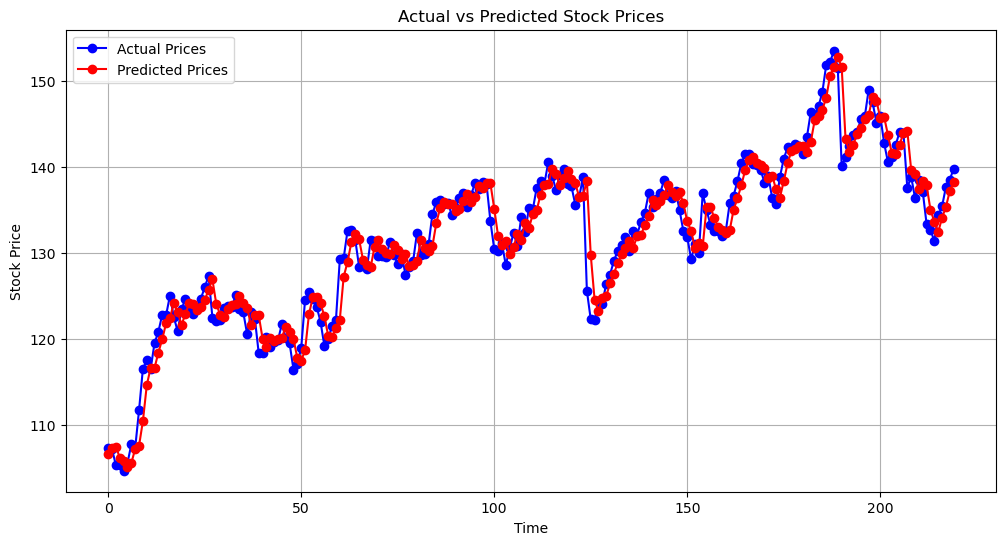

In [29]:
plot_results(actual_values, predictions)